# ADASモデル：景気循環の定量的分析

In [1]:
# CELL PROVIDED
# import piplite
# await piplite.install(['py4macro','japanize-matplotlib-jlite'])
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (5, 3.5)

次のコードを実行してください。

In [2]:
# CELL PROVIDED
import japanize_matplotlib_jlite
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import py4macro

## 本章の目的

* 回帰分析，差分方程式，ランダム変数の３つのツールを使い，総需要・総供給（ADAS）モデルの定量的（数量的）分析をおこなう。
* 定量的分析の内容
    * ADASモデルのパラメータの値をデータの特徴と整合的になるように定める（カリブレーション）
    * ADASモデルの安定性を確認する
    * 総需要ショックと総供給ショックの産出量と価格に対する影響をインパルス反応関数を使い考察する。
    * 確率的シミュレーションをおこない，**データの統計的な特徴を再現**できるかを検討し，ADASモデルを評価する。

## ADASモデル

### モデルの構造

**短期総供給曲線（AS）**

* $Y_t=$ 産出量の対数
* $Y_{*}=$ 自然産出量の対数
    * 資本蓄積や技術進歩などにより決定される。
    * トレンドに対応する。
    * ADASモデルでは一定と仮定する。供給・需要ショックは一時的なものであり，トレンドには影響しないと仮定する。
* $P_t=$ 物価水準の対数
* $P_{*}=$ 物価水準の対数
    * トレンドに対応する。
    * ここでは一定と仮定する。下で仮定する供給ショックは一時的なものであり，トレンドには影響しないと仮定する。
* $v_t=$ 供給ショック

$$
P_t=P_{t}^e+a(Y_t-Y_{*})+v_t
\tag{0a}
$$

**総需要曲線 (IS-LM)**

* $Y_t=$ 総需要の対数
* $P_t=$ 物価水準の対数
* $u_t=$ 需要ショック

$$
Y_t=b-c P_t + u_t
\tag{0b}
$$

**適応的期待**

$$
P_t^e= P_{t-1}
\tag{0c}
$$

**ショック項はホワイト・ノイズ**

* $u_t\sim\text{WN}(0,\sigma_u^2)$
* $v_t\sim\text{WN}(0,\sigma_v^2)$

**長期均衡，または定常状態（steady state）**

* $u_{t}=v_t=0$：ショックはない
* $P_t=P_*$
* $Y_t=Y_*$

### 均衡式

以下の変数を定義

* $p_t=P_t-P_*$：価格水準のトレンドからの％乖離
* $y_t=Y_t-Y_*$：産出量のトレンドからの％乖離

#### 供給曲線

$$\begin{align*}
P_{t}&=P_{t-1}+a(Y_{t}-Y_{*})+v_t \\
P_{t}-P_{*}&=(P_{t-1}-P_{*})+a(Y_{t}-Y_{*})+v_t \\
p_t &= p_{t-1}+ay_t +v_t
\end{align*}$$

#### 総需要曲線

定常状態では

$$
Y_*=b-c P_* 
$$

従って，

$$\begin{align*}
Y_t&=b-c P_t + u_t \\
Y_t-Y_*&=b-Y_*-c P_t + u_t \\
Y_t-Y_*&=cP_*-c P_t + u_t \\
y_t&=-cp_t + u_t
\end{align*}$$

**長期均衡，または定常状態（steady state）**

* $u_{t}=v_t=0$：ショックはない
* $p_* =0$：トレンドからの％乖離はゼロ
* $y_* =0$：トレンドからの％乖離はゼロ

**このモデルにおけるホワイト・ノイズのショック項$u_t$と$v_t$の経済学的な意味**

* 長期的な均衡である$Y_*$と$P_*$に影響を与えないと仮定する。
* $Y_*$と$P_*$は$u_t$と$v_t$以外の要因によって決定されると仮定する。

## 景気循環のデータ

＜$y_t$と$p_t$の解釈＞

* $Y_{*}$と$Y_{*}$は長期トレンドに対応している。
* $y_t$と$p_t$はGDPとCPIのトレンドからの％乖離に対応している。

In [3]:
df = py4macro.data('jpn-q')

In [4]:
df.columns

Index(['gdp', 'consumption', 'investment', 'government', 'exports', 'imports',
       'capital', 'employed', 'unemployed', 'unemployment_rate', 'hours',
       'total_hours', 'inflation', 'price', 'deflator'],
      dtype='object')

`gdp_cycle`と`price_cycle`は，`0`を中心に上下する系列となる。
AD-ASモデルに合わせて，`100`を中心に変動するように変更する。

In [5]:
for c in ['gdp','deflator']:
    
    df[c+'_cycle'] = np.log(df[c]) - py4macro.trend( np.log(df[c]) )
    
df.head()

,gdp,consumption,investment,government,exports,imports,capital,employed,unemployed,unemployment_rate,hours,total_hours,inflation,price,deflator,gdp_cycle,deflator_cycle
,,,,,,,,,,,,,,,,,
1980-01-01,269747.5,153290.7,65029.2,73039.5,18383.8,24278.8,833041.425949,5506.000000,107.666667,1.900000,124.7,686598.200000,5.766667,71.011939,91.2,0.003269,-0.025798
1980-04-01,268521.8,153551.9,65316.6,72164.5,18631.4,25454.5,843748.581006,5525.666667,110.000000,1.966667,124.8,689603.200000,8.166667,72.917251,93.4,-0.010845,-0.006555
1980-07-01,274183.1,155580.0,65765.9,72663.8,18449.3,23885.7,855449.381902,5561.333333,116.000000,2.033333,124.0,689605.333333,8.200000,73.897654,94.4,0.000457,-0.000482
1980-10-01,279601.8,156162.4,66017.5,74761.1,19705.4,23716.5,867991.306098,5551.333333,123.333333,2.166667,124.0,688365.333333,8.100000,74.767147,95.4,0.010468,0.005515
1981-01-01,281995.7,156757.7,66259.0,76127.6,20289.5,24174.1,878387.487376,5568.666667,124.333333,2.200000,123.6,688287.200000,6.833333,75.690241,95.6,0.009441,0.003126


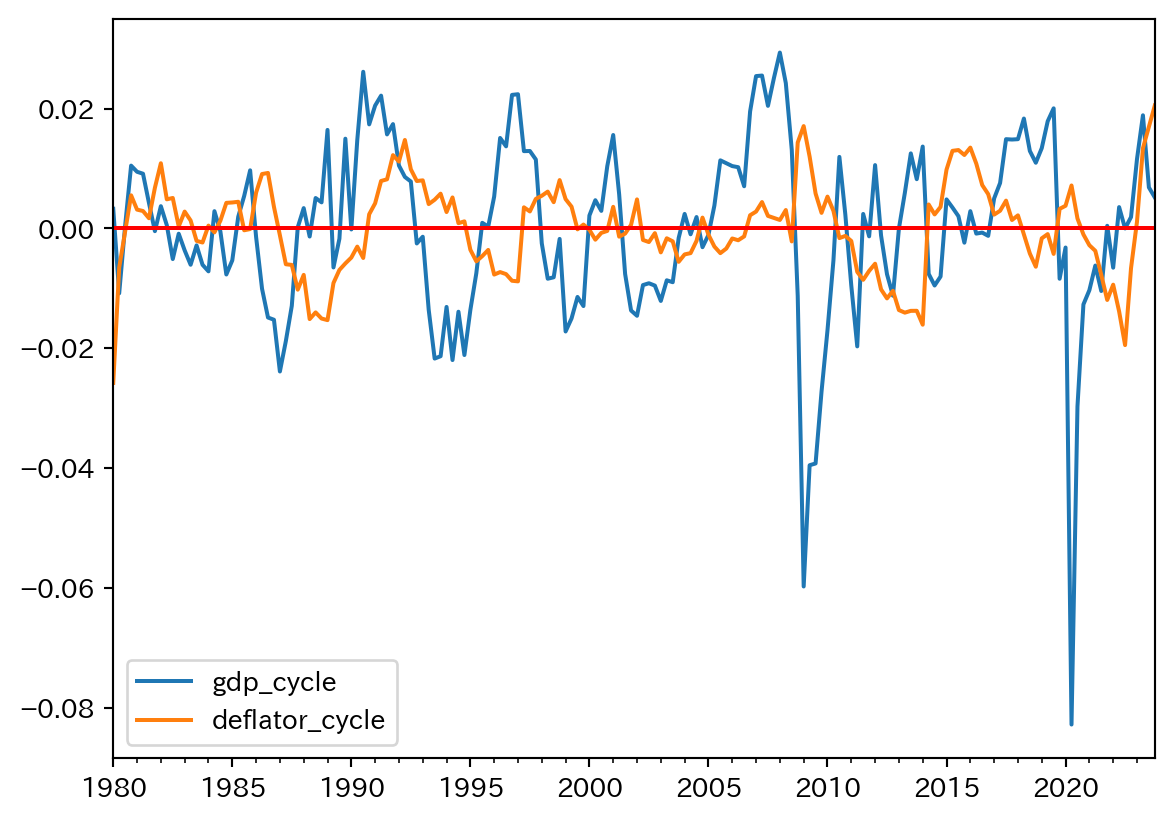

In [6]:
ax_ = df.plot(y=['gdp_cycle','deflator_cycle'])
ax_.axhline(0, color='red')

**データの特徴１**

In [7]:
y_std = df.loc[:,'gdp_cycle'].std()
p_std = df.loc[:,'deflator_cycle'].std()
print(f'GDPのトレンドからの％乖離の標準偏差：{y_std:.6f}')
print(f'デフレータのトレンドからの％乖離の標準偏差：{p_std:.6f}')

# 不偏分散の平方根

GDPのトレンドからの％乖離の標準偏差：0.014833
デフレータのトレンドからの％乖離の標準偏差：0.007490


**データの特徴２**

In [8]:
y_autocorr = df.loc[:,'gdp_cycle'].autocorr()
p_autocorr = df.loc[:,'deflator_cycle'].autocorr()
print(f'GDPのトレンドからの％乖離の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの％乖離の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの％乖離の自己相関係数：0.697
デフレータのトレンドからの％乖離の自己相関係数：0.830


強い持続性

**データの特徴３**

In [9]:
yp_corr = df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]
print(f'GDPとデフレータの％乖離の相関係数：{yp_corr:.3f}')

GDPとデフレータの％乖離の相関係数：-0.153


この値は同じ期の相関係数であり，非常に弱い関係にある。

これらのデータの特徴をどこまで**再現**できるかでAD-ASモデルを評価する。

## カリブレーションと定量的（数量的）マクロ経済学

### はじめに

データに基づき，モデルの次の4つのパラメーターの値を決めていく

* $a$，$c$，$\sigma_u$，$\sigma_v$ （標準偏差）

パラメーターの値の決め方には主に次の２つある。

1. データに基づいて計量経済学的な手法を用いて推定した結果を使う。
1. 既存の実証研究で報告され推定値を使う。

多くの研究の場合，これらの方法を駆使して値を決めることになる。
以下では１番目の方法を使い議論を進めることにする。

### カリブレーション

２つの体重計があるとしよう。

* 市販の正確な体重計
* 自作の体重計で，精度に欠ける。
    * スイッチが取り付けられている。
    * 市販の正確な体重計で人の体重を測りおり，スイッチを調整して手作り体重計でも同じ体重が表示されるようにする。

カリブレーション

* 基準となる機器に基づいて測定器の誤差をなくすための調整をおこなうこと

### 定量的（数量的）マクロ経済学

最近のマクロ経済学の研究で広く使われており，その分野を定量的（数量的）マクロ経済学と呼ぶ。
ここではAD-ASモデルに応用しようというのが目的である。
体重計の例を使うと，AD-ASモデルと実際経済の関係は次のようになる。

* 市販の正確な体重計　→　日本経済
* 手作り体重計　→　ADASモデル
* 手作り体重計のスイッチ　→　ADASモデルのパラメーター（外生変数）
* スイッチの調整　→　パラメーターの値の設定
* カリブレーションで使うデータ
    * 自分の体重　→　景気循環に関する特徴
* 評価方法
    * 他の人の体重を測り手作り体重計の誤差を確認　→　ADASモデルのパラメーターの設定に使われていないデータをどれだけ説明できるかの確認

### 均衡式

均衡式は次式で与えられる。

$$\begin{align*}
p_{t}&=p_{t-1}+ay_{t}+v_{t} \tag{AS曲線}\\
y_t&=-c p_t + u_t\tag{AD曲線}
\end{align*}$$

#### 供給曲線の書き換え

AD曲線をAS曲線に代入する

$$\begin{align*}
p_{t}
&=p_{t-1}+a(-c p_{t} + u_{t})+v_{t} \\
(1+a c)p_{t}&=p_{t-1} +a u_{t}+v_{t}
\end{align*}$$

$$
p_{t}=h p_{t-1}+h\left(a u_{t}+v_{t}\right)
\tag{AS曲線＊}
$$

ここで

$$
h\equiv\frac{1}{1+a c}<1
\tag{h}
$$

#### 需要曲線の書き換え

式(AS曲線＊)を(AD曲線)に代入し，$h$の定義を利用し整理すると次式となる。

$$
\begin{aligned}
y_t
&=-c\left[hp_{t-1}+h\left(a u_{t}+v_{t}\right)\right]+u_t\\
&=-ch p_{t-1}-ch\left(a u_{t}+v_{t}\right)+u_t\\
&=-ch p_{t-1}+(1-ach)u_t-chv_t\\
&=-ch p_{t-1}+\left(1-\dfrac{ac}{1+ac}\right)u_t-chv_t\\
&=-ch p_{t-1}+\dfrac{1}{1+ac}u_t-chv_t
\end{aligned}
$$

$$
y_t=-ch p_{t-1}+hu_t-chv_t
\tag{AD曲線＊}
$$

#### 書き換えた均衡式

即ち，AD-ASモデルは次式で表すことができる。

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
\tag{AS曲線＊}
$$

$$
y_t=-ch p_{t-1}+h(u_t-cv_t)
\tag{AD曲線＊}
$$

* $p_{t-1}$が与えられると，$p_t$と$y_t$の両方が決定される。
* $y_{t-1}$は，$p_t$と$y_t$の決定に直接的に影響を与えない。
* $p_t$は式(AS曲線＊)のみで決定される
* 安定性は式(AS曲線＊)によって決定されることになる。　→　$h$の値が安定性を決定する。

**長期均衡，または定常状態（steady state）**

$$
u_{t}=v_t=0,\qquad
y_t=0,\qquad
p_{t}=p_{t-1}=0
$$

### スイッチ調整の準備：$h$の推定値

均衡式(AS曲線＊)は$p_t$の差分方程式となっており，自己回帰モデルとなっている。

$$
p_{t}=hp_{t-1} + e_{pt}
\tag{回帰AS}
$$

* $e_{pt}\equiv h\left(a u_{t}+v_{t}\right)$

式(3)を回帰式と捉えて，$h$の推定値を求める。
説明変数である$p_{t-1}$は誤差項$e_t$とは相関していないため$h$の推定値は一致性を満たすことになる。

まず，`df`のメソッド`.shift()`を使って`deflator_cycle`を１期ずらした列を`deflator_cycle_lag`として`df`に追加しよう。

In [10]:
df['deflator_cycle_lag'] = df['deflator_cycle'].shift()
df.iloc[:5,-5:]

,price,deflator,gdp_cycle,deflator_cycle,deflator_cycle_lag
,,,,,
1980-01-01,71.011939,91.2,0.003269,-0.025798,NaN
1980-04-01,72.917251,93.4,-0.010845,-0.006555,-0.025798
1980-07-01,73.897654,94.4,0.000457,-0.000482,-0.006555
1980-10-01,74.767147,95.4,0.010468,0.005515,-0.000482
1981-01-01,75.690241,95.6,0.009441,0.003126,0.005515


`deflator_cycle_lag`には１期前の`deflator_cycle`の値が並んでいるのが確認できる。

まず回帰分析をおこない，その結果を表示する。

In [11]:
res_h = smf.ols('deflator_cycle ~ deflator_cycle_lag', data=df).fit()
print(res_h.summary())

                            OLS Regression Results                            
Dep. Variable:         deflator_cycle   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     384.1
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           8.56e-46
Time:                        11:11:28   Log-Likelihood:                 716.66
No. Observations:                 175   AIC:                            -1429.
Df Residuals:                     173   BIC:                            -1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0002      0

* 残差の系列相関と不均一分散の可能性は排除できない。より洗練された推定方法を使用可能だが、このままの数値を使う。

式(3)は`AR(1)`であるため，$\hat{h}$は$p_t$の自己相関係数でもあり，非常に高い持続性が特徴となっている。

以下に続く分析のために，次の変数を作成しておこう。

In [12]:
hhat = res_h.params['deflator_cycle_lag']  # hの推定値
ep = res_h.resid        # 推定式の残差

### １つ目のスイッチ：$c$の値

ここでは`hhat`を利用して`c`の推定値を計算する。
均衡式(1)を(2)に代入しよう

$$
y_t = dp_{t-1} + e_{yt}
\tag{回帰AD}
$$

* $d\equiv -ch$
* $e_{yt}\equiv (1-ach)u_t-chv_t=hu_t-chv_t$

説明変数$p_{t-1}$は誤差項$e_{yt}$と相関しておらず，$d$の推定値は一致性を満たすことになる。
推定結果を表示しよう。

In [13]:
res_d = smf.ols('gdp_cycle ~ deflator_cycle_lag', data=df).fit()
print(res_d.summary())

                            OLS Regression Results                            
Dep. Variable:              gdp_cycle   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     7.398
Date:                Thu, 19 Dec 2024   Prob (F-statistic):            0.00719
Time:                        11:11:28   Log-Likelihood:                 492.28
No. Observations:                 175   AIC:                            -980.6
Df Residuals:                     173   BIC:                            -974.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -6.676e-05      0

* 残差の系列相関と不均一分散の可能性は排除できない。より洗練された推定方法を使用可能だが、このままの数値を使う。

$d$の推定値である$\hat{d}$は負であり，モデルに沿った結果である。

In [14]:
dhat = res_d.params['deflator_cycle_lag']  # dの推定値

$-d\equiv ch$となり，$c$の推定値を次式で計算することができる。

$$
\hat{c} = -\frac{\hat{d}}{\hat{h}}
$$

この値を`chat`に割り当てよう。

In [15]:
chat = -dhat / hhat
chat

np.float64(0.5002776200259235)

後に続く計算のために次の変数も作成しておく。

In [16]:
ey = res_d.resid        # 推定式(4)の残差

### ２つ目のスイッチ：$a$の値

式(h)では，$h$は$a$と$c$の関数となっている。
すでに$h$と$c$の推定値を計算しているため，この式を使うことにより簡単に$a$の推定値を計算することができる。
式(h)を整理すると次式となる。

$$
\hat{a} = \left(\dfrac{1}{\hat{h}}-1\right)\frac{1}{\hat{c}}
$$

計算結果を`ahat`に割り当てよう。

In [17]:
ahat = (1/hhat - 1) / chat
ahat

np.float64(0.44058226715969134)

### ３つ目のスイッチ：$\sigma_v$の値

$\sigma_v^2$の値も回帰式の結果を使い設定する。
式(回帰AS)の誤差項$e_{pt}$は$u_t$と$v_t$の線形関数となっており，同様に，式(回帰AD)の誤差項$e_{yt}$も$u_t$と$v_t$の線形関数となっている。
以下に再掲する。

$$
\begin{align*}
e_{pt}&=h(a u_{t}+v_{t})\\
e_{yt}&=h(u_t-cv_t)
\tag{5}
\end{align*}
$$

$a$と$h$にはその推定値$\hat{a}$と$\hat{h}$を使い，$e_{pt}$と$e_{yt}$については残差$\hat{e}_{pt}$と$e_{yt}$を用いることにより，
$u_t$と$v_t$を計算することができる。
式(5)は$u_t$と$v_t$の線形連立方程式となっているため，簡単に次のように書き直すことができる。

$$
v_t=e_{pt}-ae_{yt}
\tag{6}
$$

$$
u_t=ce_{pt}+e_{yt}
\tag{7}
$$

ここで次の変数を使い$\hat{v}_t$と$\hat{u}_t$を計算する。

* $\hat{a}\quad\Rightarrow\quad a$
* $\hat{c}\quad\Rightarrow\quad c$
* $\hat{e}_{pt}\quad\Rightarrow\quad e_{pt}$
* $\hat{e}_{yt}\quad\Rightarrow\quad e_{yt}$

ここで`^`は推定値を表している。

まず式(6)を使い，結果を`vt`に割り当てよう。

In [18]:
vt = ep - ahat*ey

`vt`のデータ型は`Series`であり，メソッド`.std()`を使うと簡単に`vt`の標準偏差を計算することができる。

In [19]:
v_std = vt.std()
v_std

np.float64(0.007494205944126833)

### ４つ目のスイッチ：$\sigma_u$の値

同様に，式(7)を使うと，$\hat{u}_t$の分散を計算することができる。
`u_std`に割り当てる。

In [20]:
ut = ey + chat*ep
u_std = ut.std()
u_std

np.float64(0.014756834709148486)

### パラメーターの値

In [21]:
print(f'aの値：{ahat:.3f}')
print(f'cの値：{chat:.3f}')
print(f'uの標準偏差：{u_std:.6f}')
print(f'vの標準偏差：{v_std:.6f}')

aの値：0.441
cの値：0.500
uの標準偏差：0.014757
vの標準偏差：0.007494


需要ショック（$u_t$）の標準偏差が比較的に大きく，供給ショック（$v_t$）の約2倍となっている。

## コードの基本形

シミュレーションをおこなう際，コードは関数にまとめて書くことにする。
コードは次のようなパターンになっている。

関数の中身

1. アップデート用の変数を用意
1. 空のリストを作成
1. `for`ループに`.append()`を使う
1. `DataFrame`を返す

簡単な例を考えてみよう。

In [22]:
def my_func(a, n):

    x = 0

    lst = [x]

    for i in range(n):

        x = x + a

        lst.append(x)
        
    return pd.DataFrame({'col': lst})

In [23]:
my_func(2, 5)

,col
0,0
1,2
2,4
3,6
4,8
5,10


## ADASモデルの安定性

$u_t=v_t=0$，$t=0,1,2,\cdots$としよう。
即ち，需要ショック・供給ショックはない状態でAD-ASモデルの安定性を考察する。

$u_t=v_t=0$の場合の均衡式

$$
p_{t}=hp_{t-1}
\tag{1a}
$$

$$
y_t=-chp_{t-1} 
\tag{2a}
$$

$\hat{h}<1$となるため安定的だとわかる。

**練習問題としてコードを書いて安定性を確かめよう！**

## インパルス反応関数

インパルス反応関数とは，ある特定のショック（$u_t$もしくは$v_t$）が一定期間（例えば、１期間）発生した場合，`y_t`と`p_t`がどのように変化するかを示す時系列のグラフをである。
インパルス反応関数により，ショックの波及効果を可視化できる。
また，後で考察する確率的シミュレーションの結果を理解する上でも有用な情報となる。

### コード

$$
p_{t}=hp_{t-1}+h\left(a u_{t}+v_{t}\right)
\tag{AS曲線＊}
$$

$$
y_t=-ch p_{t-1}+h(u_t-cv_t)
\tag{AD曲線＊}
$$

次のコードでは，ショック項である$u_t$と$v_t$は１期間だけ変化すると仮定する。
従って，`u_std`と`v_std`は無関係となるため，コードには使わない。
一方，`a`，`c`は上で推定した値を使うこととする。

    """引数
        u: AD曲線へのショックの大きさ（デフォルト：0）
        v: AS曲線へのショックの大きさ（デフォルト：0）
        n_after: ショック発生後0に戻った後の計算回数（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        y, p, u, vのDataFrame

    * 最初の３期間はショックゼロ"""

In [24]:
def one_period_impulse(u=0, v=0, n_after=20, a=ahat, c=chat):
    """引数
        u: AD曲線へのショックの大きさ（デフォルト：0）
        v: AS曲線へのショックの大きさ（デフォルト：0）
        n_after: ショック発生後0に戻った後の計算回数（デフォルト：20）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
    戻り値：
        y, p, u, vのDataFrame

    * 最初の３期間はショックゼロ"""

    # === hの定義 ==========
    h = 1 / ( 1+a*c )
    
    # === 初期値，forループのアップデート用変数 ==========
    p = 0       # 最初は定常状態に設定
    y = 0       # 最初は定常状態に設定
    
    # === 結果を格納するリストの作成 ==========
    # 最初の３つの要素は定常状態に設定
    y_lst = [0]*3
    p_lst = [0]*3
    u_lst = [0]*3
    v_lst = [0]*3

    # === ショック発生時 ==========
    (p, y) = ( h*p + h*( a*u+v ),     # 引数のuとvが使われる
               -c*h*p + h*( u-c*v )   # 引数のuとvが使われる
             )
        
    y_lst.append(y)
    p_lst.append(p)
    u_lst.append(u)          # 引数のuが使われる
    v_lst.append(v)          # 引数のvが使われる
        
    # === ショック後 ==========
    u, v = 0, 0     # ショックを0に戻す

    for _ in range(n_after):
        (p, y) = ( h*p + h*( a*u+v ),
                   -c*h*p + h*( u-c*v )
                 )

        y_lst.append(y)
        p_lst.append(p)
        u_lst.append(u)
        v_lst.append(v)
    
    # === 変数の辞書 ==========
    dic = {'y':y_lst, 'p':p_lst, 'u':u_lst, 'v':v_lst}
    
    # === DataFrameを返す ==========
    return pd.DataFrame(dic)

### プロット

供給ショック

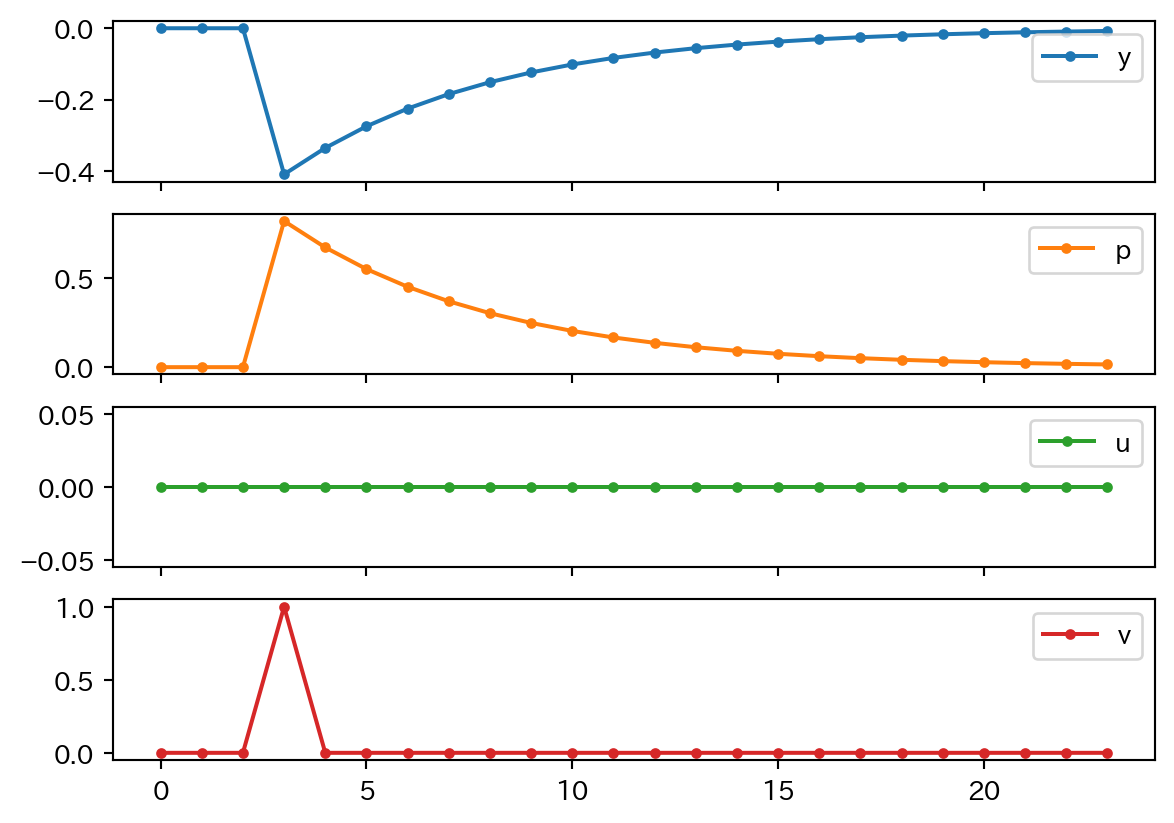

In [25]:
one_period_impulse(v=1).plot(subplots=True, marker='.')
pass

需要ショック

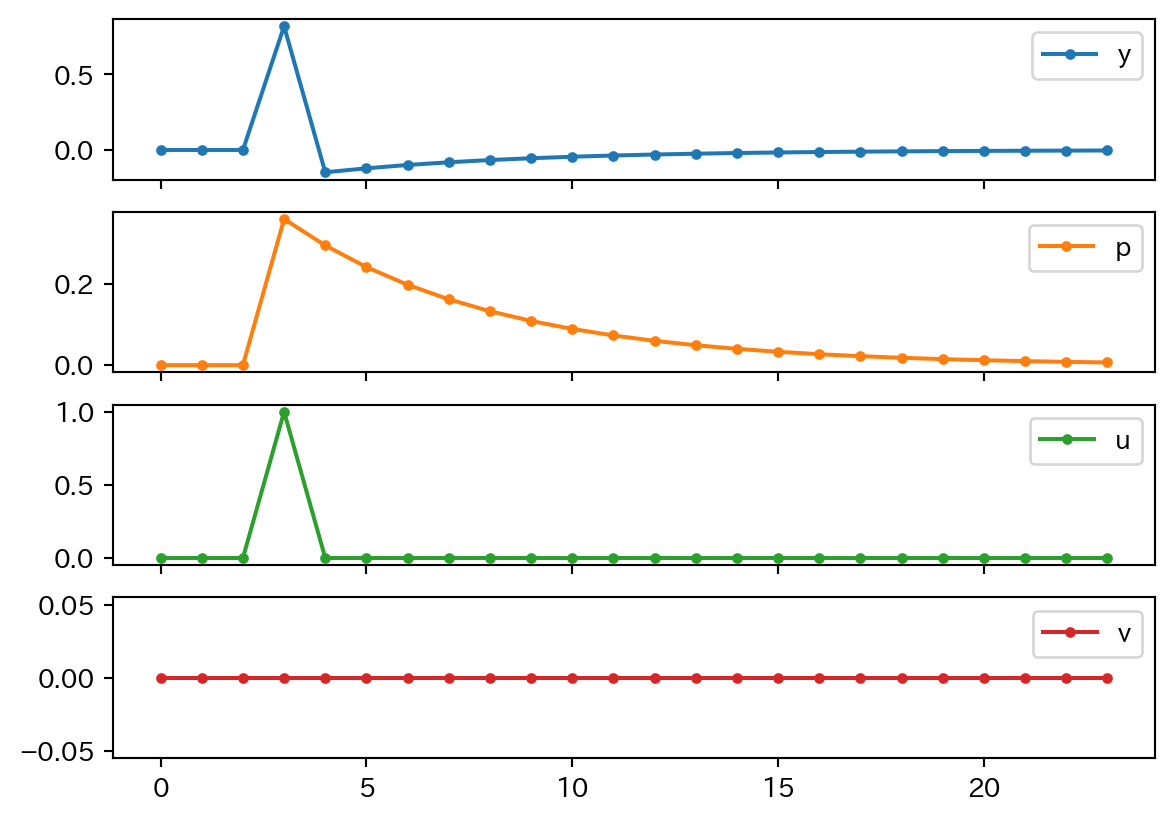

In [26]:
one_period_impulse(u=1).plot(subplots=True, marker='.')
pass

供給＋需要ショック

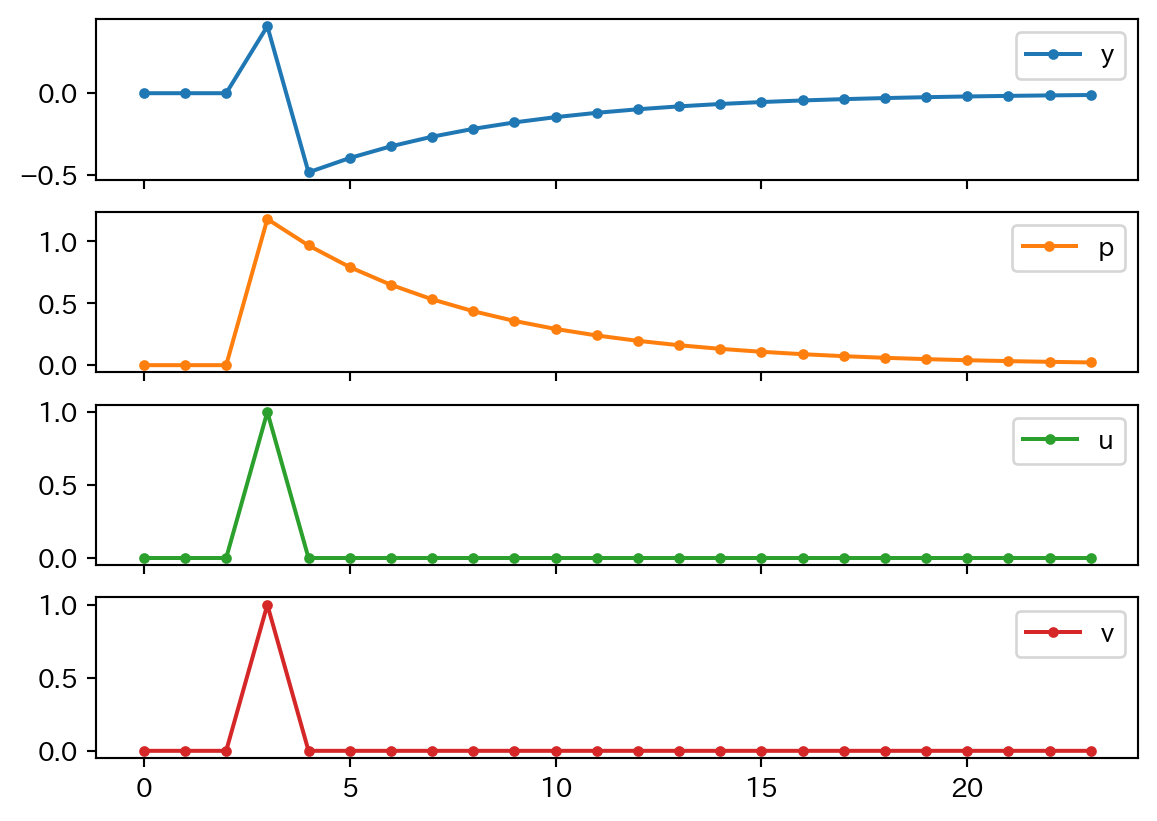

In [27]:
one_period_impulse(u=1, v=1).plot(subplots=True, marker='.')
pass

## 確率的シミュレーション

毎期`u`，`v`にランダムな値を割り当てシミュレーションをおこなう。

* $u_t\sim\text{Normal}(0,\sigma_u^2)$
* $v_t\sim\text{Normal}(0,\sigma_v^2)$

### コード

`a`，`c`，$\sigma_u^2$，$\sigma_v^2$には上で設定した値を使うこととする。

    """
    引数：
        n: シミュレーションの回数（デフォルト：100）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
        ustd: 需要ショックの標準偏差（デフォルト：u_std）
        vstd: 供給ショックの標準偏差（デフォルト：v_std）
    戻り値：
        y, p, u, vのDataFrame"""

In [28]:
def stochastic_sim(n=100, a=ahat, c=chat, ustd=u_std, vstd=v_std):
    """
    引数：
        n: シミュレーションの回数（デフォルト：100）
        a: aの値（デフォルト：ahat）
        c: cの値（デフォルト：chat）
        ustd: 需要ショックの標準偏差（デフォルト：u_std）
        vstd: 供給ショックの標準偏差（デフォルト：v_std）
    戻り値：
        y, p, u, vのDataFrame"""
    
    # === hの定義 ==========
    h = 1/(1+a*c)
    
    # === 初期値，forループのアップデート用変数 ==========
    p = 0   # 最初は定常状態に設定
    y = 0   # 最初は定常状態に設定

    # === 結果を格納するリストの作成 ==========
    y_lst = []
    p_lst = []
    u_lst = []
    v_lst = []
    
    # === ランダム変数の「種」==========
    rng = np.random.default_rng()

    # === ループ計算 ==========
    for _ in range(n):
        # ADのショック項
        u = rng.normal(0, ustd)

        # ASのショック項
        v = rng.normal(0, vstd)
        
        (p, y) = ( h*p + h*( a*u+v ),
                   -c*h*p + h*( u-c*v )
                 )
                    
        y_lst.append(y)
        p_lst.append(p)
        u_lst.append(u)
        v_lst.append(v)
            
    # === 変数の辞書 ==========
    dic = {'y':y_lst, 'p':p_lst, 'u':u_lst, 'v':v_lst}

    # === DataFrameを返す ==========
    return pd.DataFrame(dic)

### プロット

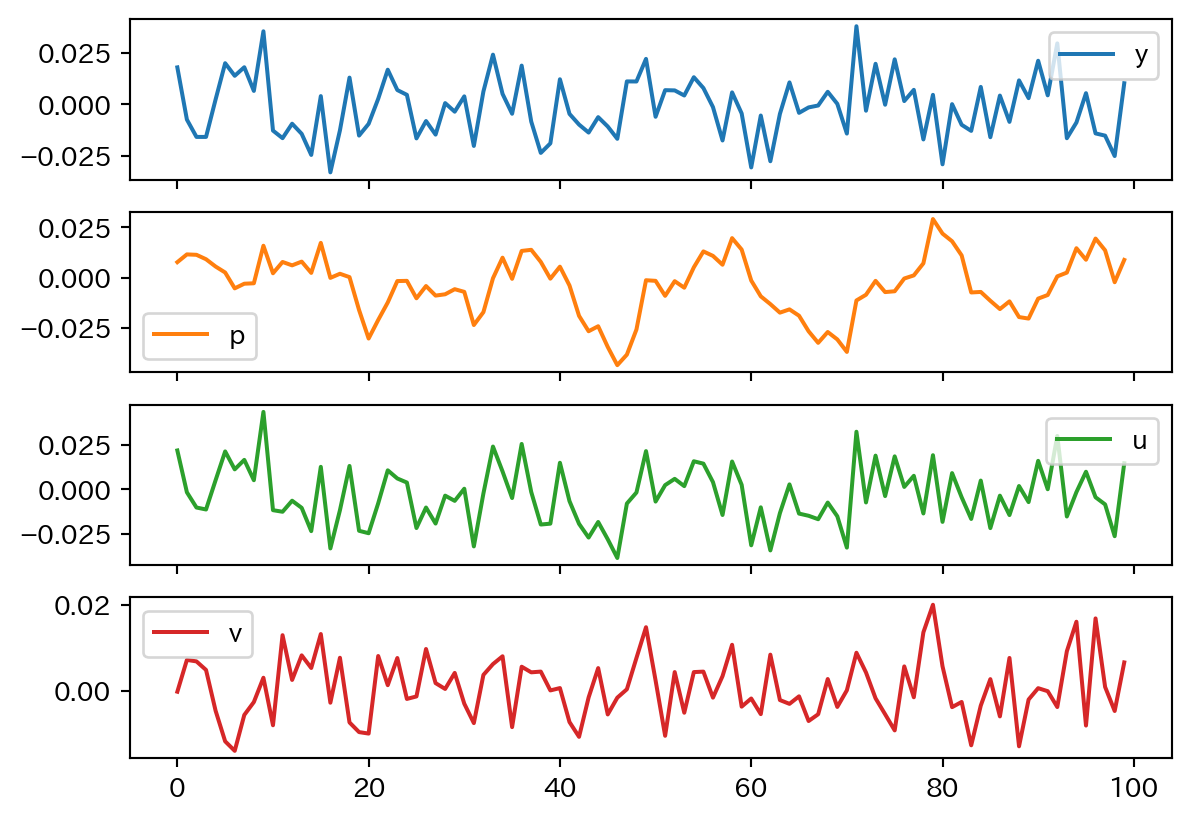

In [29]:
sim = stochastic_sim(n=100)
sim.plot(subplots=True)
pass

統計量の計算のために`n=1_000_000`を使う。

In [30]:
sim = stochastic_sim(n=1_000_000)

### GDPと価格水準の％乖離の標準偏差

**データの値**

In [31]:
print(f'GDPのトレンドからの％乖離の標準偏差：{y_std:.5f}')
print(f'デフレータのトレンドからの％乖離の標準偏差：{p_std:.5f}')

GDPのトレンドからの％乖離の標準偏差：0.01483
デフレータのトレンドからの％乖離の標準偏差：0.00749


**シミュレーションの結果**

In [32]:
for value in ['y','p']:
    print(f'{value}の標準偏差:{sim[value].std():.5f}')

yの標準偏差:0.01378
pの標準偏差:0.01420


* GDPの標準偏差はデータと近い値になっている。
* 価格水準の標準偏差は大きすぎる結果となている。

### 自己相関係数

**データの値**

In [33]:
print(f'GDPのトレンドからの％乖離の自己相関係数：{y_autocorr:.3f}')
print(f'デフレータのトレンドからの％乖離の自己相関係数：{p_autocorr:.3f}')

GDPのトレンドからの％乖離の自己相関係数：0.697
デフレータのトレンドからの％乖離の自己相関係数：0.830


**シミュレーションの結果**

In [34]:
for value in ['y','p']:
    print(f'{value}:{sim[value].autocorr():.3f}')

y:0.048
p:0.819


* `y`の自己相関係数は低すぎる。持続性が捉えられていない。
* `p`の自己相関係数はデータと近い値になっている。

### `p`と`y`の％乖離の相関係数：同じ期

**データの値**

In [35]:
df.loc[:,['gdp_cycle', 'deflator_cycle']].corr().iloc[0,1]

np.float64(-0.15298375930457533)

**シミュレーション**

In [36]:
sim[['y', 'p']].corr().iloc[0,1]

np.float64(-0.11388783995645464)

* 近い値となっている。

### 結果のまとめと拡張

データと`100,000`回のシミュレーション結果

＜まとめ＞

* GDP標準偏差の自己相関係数は概ね近い値（◯）
* デフレータの標準偏差の値は高すぎる（X）
* GDPの自己相関係数は低すぎる（X）
* デフレータの自己相関係数は近い値（△）
* 同期のGDPと価格の相関係数は近い値（◯）

捉えることができていないデータの特徴もあるが，全く的外れな結果ではない。
単純なAD-ASモデルにしてはまずまずの結果と言えるのではないだろうか。

次に，モデルの簡単な拡張に触れる。ホワイト・ノイズは前期のショックと今期のショックは何の関係もない独立を意味する。総需要ショックと総供給ショックは，そうなのだろうか。例えば，政府支出を考えてみよう。政府は，増税を実施すると，１四半期後に減税するような行動は取らない。少なくともある期間，政策を一貫して実施することになる。投資はどうだろうか。１四半期毎に企業は投資をコロコロと変えるような行動はしない。消費者の嗜好の変化も需要ショックとして現れるが，ファッションで今季は赤が流行り，１四半期後には青が流行るということではない。すなわち，ショックはホワイト・ノイズではなく，ある程度の**持続性**が存在すると想定できる。総供給ショックも同じように考えることができる。

この特徴を捉えるために，総需要ショックと総供給ショックに次の自己回帰モデルを想定することができる。

$$
u_t=\rho_u u_{t-1}+e^u_t,\qquad e^u_t\sim\text{WN}(0,\sigma_{eu}^2)
\tag{10}
$$

$$
v_t=\rho_v v_{t-1}+e^v_t,\qquad e^v_t\sim\text{WN}(0,\sigma_{ev}^2)
\tag{11}
$$

新たなパラメーターとして$\rho_u$，$\rho_v$，$\sigma_{eu}^2$，$\sigma_{ev}^2$の４つがあるが，これらもデータを使って次のように推定することが可能である。
1. 式(6)の$\hat{v}$を使い，(10)を推定式として$\hat{\rho}_v$を推定する。またその残差の分散を$\sigma_{ev}^2$とする。
1. 式(7)の$\hat{u}$を使い，(11)を推定式として$\hat{\rho}_u$を推定する。またその残差の分散を$\sigma_{eu}^2$とする。

### ADASモデルの評価

AD-ASモデルは，経済を理解する上では非常に有用だが，データの一部の特徴の説明力に欠ける。
どう理解すれば良いだろうか。経済学研究で用いる推論方法を考えてみよう。

帰納的推論（inductive inference）

* 真のモデルが存在するという前提の下でデータを使い推定するモデルの蓋然性を検討する手法である。
* 典型的な例として，計量経済分析が当てはまる。推定されたモデルは，帰納的推論の**アウトプット**ということになる。

演繹的推論（deductive inference）

* モデルを「装置」として使い，理論の含意に関して推論しようということである。モデルは**インプット**になる。例えば，AD-ASモデルで比較静学をおこない，外生変数の定性的な効果を検討する場合が当てはまる。

しかし，経済モデルは複雑な経済を抽象化した考え方に過ぎず，AD-ASモデルを含めてどのような経済モデルであっても複雑な経済の全ての側面を捉えることはできない「間違った」モデルである。
また，この章の目的はAD-ASモデルが真のモデルかどうかを判断しようということではない。
従って，データの特徴の一部を説明できないのは，単にADASモデルの限界を表していると解釈できる。

では，AD-ASモデルのどこに有用性があるのだろうか。
カリブレーションを説明する際，手作りの体重計の例を使ったがもう一度考えみよう。
カリブレーション後，70kg以上の体重は誤差が大きく使いものにならないが，70kg未満であれば誤差は許容範囲だとしてみよう。
この場合，「小学生やそれより幼い子どもの体重を測る」ことが目的であれば，手作り体重計の成功と考えることができる。
要するに，完璧な「装置」でなくとも，目的に沿ったものであれば十分だということだ。
「完璧でなくても良い」という考え方は，地図の有用性を考えれば直ぐに理解できるのではないだろうか。
地図は，実際の距離を縮尺にしており，多くの詳細が省かれている。
三宮のレストランを探す場合，世界地図は使いものにならない。
しかし，石油を運ぶタンカーの運航や宇宙衛星を落下させる際には重要な役割を果たす（政治的な目的にも有用だという主張もある）。
経済モデルは地図のようなものであり，AD-ASモデルは不完全だが，限られた目的のためであれば有用になり得るということだ。